In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Ahora puedes importar el archivo o los módulos
#from pricing_tools import *
import scipy.stats as stats
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm

In [2]:
df_path=r'C:/Users/edgar.torres/Downloads/Clase financiero/pj_sa_202402/src/AGUA'
df=pd.read_parquet(df_path)
df.head()

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,...,zona_inundable_centroids,zonas_agri,zonas_de_extraccion_minera,zonas_en_construccion,zonas_fore,zonas_hume,zonas_industriales_o_comerciales,zonas_portuarias,zonas_quemadas,zonas_verdes_urbanas
0,1033.0,552.0,31.0,NaN,31.0,99.0,4.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
1,1033.0,552.0,30.0,NaN,30.0,99.0,3.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
2,1033.0,552.0,33.0,NaN,33.0,99.0,6.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
3,1033.0,552.0,34.0,NaN,34.0,99.0,7.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
4,1033.0,552.0,36.0,NaN,36.0,99.0,6.0,1961.0,1961.0,0.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN


In [3]:
#reducir el tamaño del df para el analisis
df_muestra = df.sample(n=len(df))

In [4]:
#Variables de respuesta y peso
var_resp='stro_Corr_AGUAACAGBC'
peso='exp_corr_ACAGBC'
ano='year'

In [5]:
#Filtra los años que tienen valor mayor a 0
df_muestra=df_muestra[df_muestra[peso]>0]
df_muestra=df_muestra[df_muestra['SUPERFICIE']<20000]

In [6]:
#Genera la columna de respuesta
df_muestra['resp']=df_muestra[var_resp]/df_muestra[peso]

In [7]:
# Funcion para graficar histograma
def graficar_histograma(df, columna, bins=10, titulo="Histograma", xlabel="Valores", ylabel="Frecuencia"):
    """
    Grafica un histograma de una variable específica de un DataFrame.
    
    Parámetros:
    - df: DataFrame de pandas que contiene los datos.
    - columna: Nombre de la columna que se desea graficar (str).
    - bins: Número de bins en el histograma (opcional, por defecto 10).
    - titulo: Título del gráfico (opcional).
    - xlabel: Etiqueta para el eje X (opcional).
    - ylabel: Etiqueta para el eje Y (opcional).
    """
    # Comprobamos si la columna existe en el DataFrame
    if columna not in df.columns:
        print(f"La columna '{columna}' no se encuentra en el DataFrame.")
        return
    
    # Graficar el histograma
    plt.figure(figsize=(8, 6))
    plt.hist(df[columna].dropna(), bins=bins, color="skyblue", edgecolor="black")
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [8]:
# Funcion para graficar barras
def graficar_barras_linea(df, x_col, y_col_barras, y_col_linea, titulo="Gráfico combinado de barras y línea"):
    """
    Función para graficar un diagrama de barras con una línea superpuesta.
    
    Parámetros:
    - df: DataFrame de Pandas.
    - x_col: Nombre de la columna para el eje x (categorías).
    - y_col_barras: Nombre de la columna para el eje y de las barras (pesos).
    - y_col_linea: Nombre de la columna para el eje y de la línea (variable de respuesta).
    - titulo: Título del gráfico (opcional).
    """

    # Crear el gráfico
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Graficar las barras
    ax1.bar(df[x_col], df[y_col_barras], color='skyblue', label=y_col_barras, alpha=0.7)

    # Etiquetas para el eje de las barras
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y_col_barras, color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')

    # Crear un segundo eje Y para la línea
    ax2 = ax1.twinx()  # Comparte el mismo eje X

    # Graficar la línea
    ax2.plot(df[x_col], df[y_col_linea], color='orange', marker='o', label=y_col_linea)

    # Etiquetas para el eje de la línea
    ax2.set_ylabel(y_col_linea, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Título
    plt.title(titulo)

    # Rotar etiquetas del eje X si es necesario
    plt.xticks(rotation=90)

    # Asegurar que no se solapen los gráficos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [9]:
# Funcion para exposicion homogenea
def generar_formato_exposicion_homogenea(df, columna_interes, columna_exposicion, num_beans):
    """
    Genera un formato de beans con exposición homogénea basados en la exposición de otra columna y devuelve la columna
    de interés con el formato aplicado.

    :param df: DataFrame que contiene los datos.
    :param columna_interes: Nombre de la columna de interés que se quiere agrupar en bins.
    :param columna_exposicion: Nombre de la columna que contiene la exposición o peso.
    :param distribucion: Tipo de distribución ('normal', 'uniforme', etc.) para ajustar los beans (parámetro no usado en esta versión).
    :param num_beans: Número de beans o grupos a crear.
    :return: Serie con la columna de interés formateada en beans de exposición constante.
    """
    
    # Ordenar el DataFrame por la columna de interés para crear beans adecuados
    df = df.sort_values(by=columna_interes).reset_index(drop=True)

    # Calcular la exposición total y la exposición por cada bean
    exposicion_total = df[columna_exposicion].sum()
    exposicion_por_bean = exposicion_total / num_beans
    
    # Variable para rastrear la exposición acumulada y asignar beans
    exposicion_acumulada = 0
    limites_beans = []
    current_bean = 1
    limite_actual = df[columna_interes].iloc[0]  # Inicia en el valor mínimo
    
    # Recorrer el DataFrame fila por fila para crear los bins basados en exposición
    for i, fila in df.iterrows():
        exposicion_acumulada += fila[columna_exposicion]
        
        # Si alcanzamos la exposición deseada para este bin, guardar el límite superior
        if exposicion_acumulada >= exposicion_por_bean:
            limite_actual = fila[columna_interes]
            limites_beans.append(limite_actual)
            exposicion_acumulada = 0
            current_bean += 1
            if current_bean > num_beans:
                break  # No más beans después del número establecido
    
    # Si el número de beans es menor al solicitado, añadimos el máximo valor como último límite
    if len(limites_beans) < num_beans:
        limites_beans.append(df[columna_interes].max())
    
    # Usar pd.cut para aplicar los límites de los beans
    df['Columna_formateada'] = pd.cut(df[columna_interes], bins=[-np.inf] + limites_beans, duplicates='drop')
    
    return df['Columna_formateada']

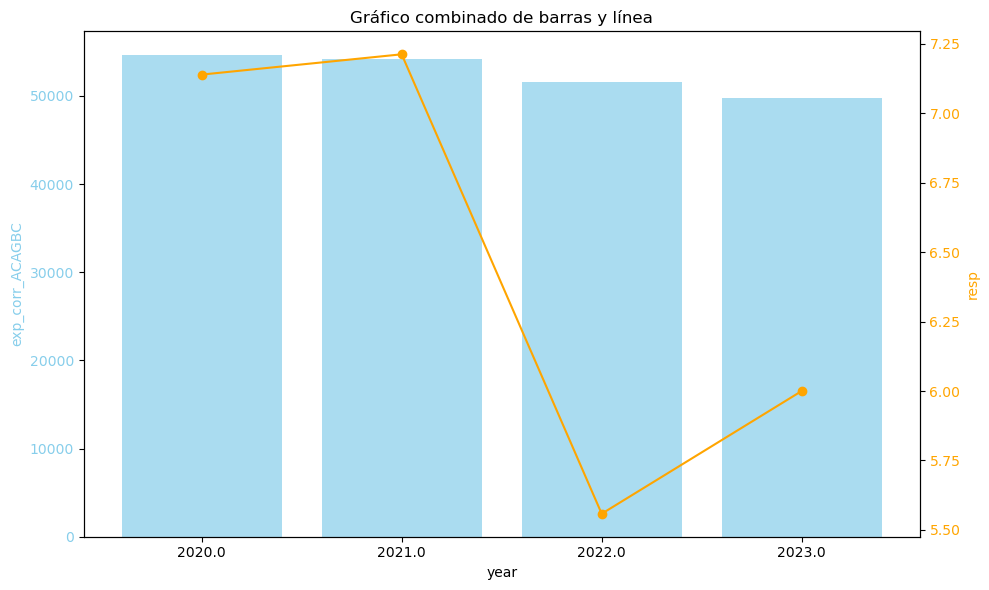

In [10]:
# Composicion de la cartera por años
df_muestra[ano]=df_muestra[ano].astype(str)
df_resumido = df_muestra.groupby(ano).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,ano,peso,'resp')

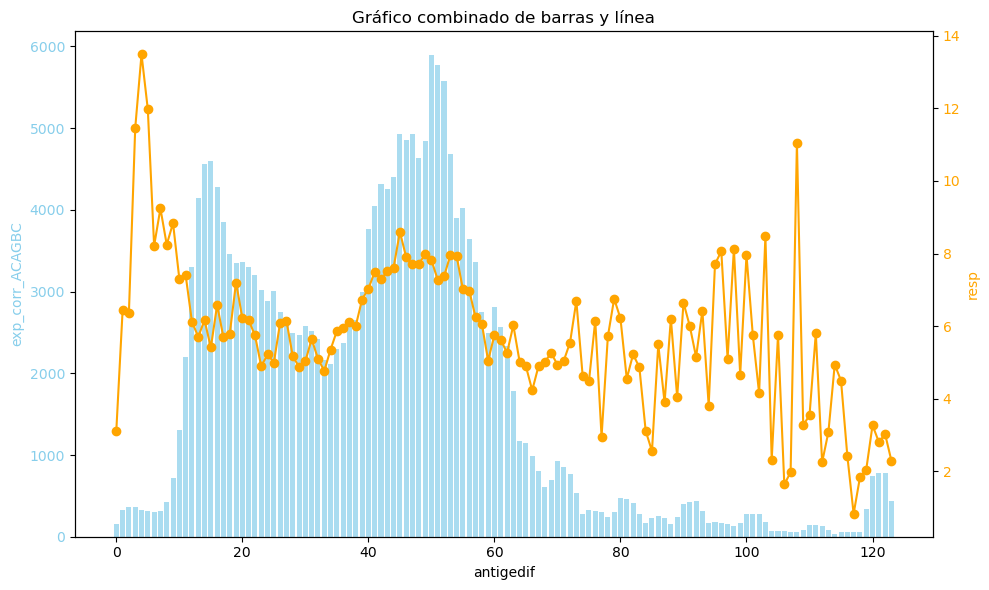

In [11]:
# Variable 1 
#Antiguedad del edificio
var1='antigedif'
df_muestra[var1].dtype
df_resumido = df_muestra.groupby(var1).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var1,peso,'resp')

In [ ]:
antig_corregida=generar_formato_exposicion_homogenea(df_muestra, 'antigedif', peso, 10)
df_muestra['antigedif_2']=antig_corregida #Sobreescribimos la columna corregida

In [ ]:
df_muestra['antigedif_2']=df_muestra['antigedif_2'].astype(str)
df_resumido = df_muestra.groupby('antigedif_2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'antigedif_2',peso,'resp')

In [ ]:
# Convertir los nan en la moda de la variable
df_muestra['antigedif_2'].replace('nan',np.nan).mode(dropna=True)[0]

In [ ]:
df_muestra['antigedif_2']=df_muestra['antigedif_2'].replace('nan','(51.0, 56.0]')
df_resumido = df_muestra.groupby('antigedif_2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'antigedif_2',peso,'resp')

In [ ]:
# Variable 2 
# SUPERFICIE
var2='SUPERFICIE'
df_muestra[var2].dtype
df_resumido = df_muestra.groupby(var2).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var2,peso,'resp')

In [ ]:
#2
SUPERFICIE_corregida=generar_formato_exposicion_homogenea(df_muestra, 'SUPERFICIE', peso, 10)
df_muestra['SUPERFICIE2']=SUPERFICIE_corregida #Sobreescribimos la columna corregida

In [ ]:
#3

df_muestra['SUPERFICIE2']=df_muestra['SUPERFICIE2'].astype(str)
df_resumido = df_muestra.groupby('SUPERFICIE2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'SUPERFICIE2',peso,'resp')

In [ ]:
#4
### Y que hacemos con los Nan? -> por ejemplo convertirlos en la moda de la variable
df_muestra['SUPERFICIE2'].replace('nan',np.nan).mode(dropna=True)[0]

In [ ]:
#5
### Ahora sustituimos los nan por el valor moda
df_muestra['SUPERFICIE2']=df_muestra['SUPERFICIE2'].replace('nan','(3824.0, 19985.0]')
df_resumido = df_muestra.groupby('SUPERFICIE2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'SUPERFICIE2',peso,'resp')

In [ ]:
# Variable 3
# Antiguedad de la vivienda
var3='ANTIGUEDAD_VIVIENDA'
df_muestra=df_muestra[df_muestra[var3]>0]
df_muestra[var3].dtype
df_resumido = df_muestra.groupby(var3).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var3,peso,'resp')

In [ ]:
#2
Antvivienda_corregida=generar_formato_exposicion_homogenea(df_muestra, 'ANTIGUEDAD_VIVIENDA', peso, 10)
df_muestra['ANTIGUEDAD_VIVIENDA2']=Antvivienda_corregida #Sobreescribimos la columna corregida

In [ ]:
#3
df_muestra['ANTIGUEDAD_VIVIENDA2']=df_muestra['ANTIGUEDAD_VIVIENDA2'].astype(str)
df_resumido = df_muestra.groupby('ANTIGUEDAD_VIVIENDA2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'ANTIGUEDAD_VIVIENDA2',peso,'resp')

In [ ]:
#4
# Convertir los nan en la moda de la variable
df_muestra['ANTIGUEDAD_VIVIENDA2'].replace('nan',np.nan).mode(dropna=True)[0]

In [ ]:
#5
### Ahora sustituimos los nan por el valor moda
df_muestra['ANTIGUEDAD_VIVIENDA2']=df_muestra['ANTIGUEDAD_VIVIENDA2'].replace('nan','(-inf, 12.0]')
df_resumido = df_muestra.groupby('ANTIGUEDAD_VIVIENDA2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'ANTIGUEDAD_VIVIENDA2',peso,'resp')

In [ ]:
#Variable 4
# Riesgo de tornado
var4='Tornado_AVG'
df_muestra=df_muestra[df_muestra[var4]>0]
df_muestra[var4].dtype
df_resumido = df_muestra.groupby(var4).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var4,peso,'resp')

In [ ]:
#2
tornado_corregida=generar_formato_exposicion_homogenea(df_muestra, 'Tornado_AVG', peso, 10)
df_muestra['Tornado_AVG2']=tornado_corregida #Sobreescribimos la columna corregida

In [ ]:
#3
df_muestra['Tornado_AVG2']=df_muestra['Tornado_AVG2'].astype(str)
df_resumido = df_muestra.groupby('Tornado_AVG2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'Tornado_AVG2',peso,'resp')

In [ ]:
#4
### Y que hacemos con los Nan? -> por ejemplo convertirlos en la moda de la variable
df_muestra['Tornado_AVG2'].replace('nan',np.nan).mode(dropna=True)[0]

In [ ]:
#5
### Ahora sustituimos los nan por el valor moda
df_muestra['Tornado_AVG2']=df_muestra['Tornado_AVG2'].replace('nan','(0, 1.0]')
df_resumido = df_muestra.groupby('Tornado_AVG2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'Tornado_AVG2',peso,'resp')

In [ ]:
# Variable 5 
# Pluviometria Anual
var5='Pluviometria_anual'
df_muestra=df_muestra[df_muestra[var5]<1500]
df_muestra[var5].dtype
df_resumido = df_muestra.groupby(var5).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var5,peso,'resp')

In [ ]:
#2
pluviometria_corregida=generar_formato_exposicion_homogenea(df_muestra, 'Pluviometria_anual', peso, 10)
df_muestra['Pluviometria_anual2']=pluviometria_corregida #Sobreescribimos la columna corregida

In [ ]:
#3
df_muestra['Pluviometria_anual2']=df_muestra['Pluviometria_anual2'].astype(str)
df_resumido = df_muestra.groupby('Pluviometria_anual2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'Pluviometria_anual2',peso,'resp')

In [ ]:
#4
### Y que hacemos con los Nan? -> por ejemplo convertirlos en la moda de la variable
df_muestra['Pluviometria_anual2'].replace('nan',np.nan).mode(dropna=True)[0]

In [ ]:
#5
### Ahora sustituimos los nan por el valor moda
df_muestra['Pluviometria_anual2']=df_muestra['Pluviometria_anual2'].replace('nan','(444.0, 469.0]')
df_resumido = df_muestra.groupby('Pluviometria_anual2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'Pluviometria_anual2',peso,'resp')

In [ ]:
#Modelo 1
factores=['year','antigedif_2','FP','SUPERFICIE2','CODPROV','Pluviometria_anual2','Tornado_AVG2','ANTIGUEDAD_VIVIENDA2']
df_muestra[factores].dtypes

In [ ]:
# Creamos variables dummy para las columnas categóricas
key_words=['year', 'antigedif_2','SUPERFICIE2','Pluviometria_anual2','Tornado_AVG2','ANTIGUEDAD_VIVIENDA2']
df_encoded = pd.get_dummies(df_muestra, columns=key_words, drop_first=True)

In [ ]:
cols_encoded = [each for each in df_encoded.columns if any(keyword in each for keyword in key_words)]
cols_encoded

In [ ]:
factores_updated=[each for each in factores if each not in key_words]
factores_updated

In [ ]:
list(set(cols_encoded+factores_updated))

In [ ]:
# Prepara los datos
df_encoded = df_encoded[list(set(cols_encoded+factores_updated))].astype('float')
df_encoded.fillna(0, inplace=True)
X=df_encoded# Selecciona las variables predictoras
X = sm.add_constant(X)            # Agrega una constante al modelo (intercepto)
y = df_muestra['resp']                   # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset = np.log(df_muestra[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar los resultados del modelo
print(resultado.summary())

In [ ]:
def calculate_bic(model):
    n = len(model.model.endog)  # Número de observaciones
    k = model.df_model + 1  # Número de parámetros (df_model incluye los coeficientes, sumamos 1 por el intercepto)
    bic = np.log(n) * k - 2 * model.llf  # BIC = ln(n) * k - 2 * log-verosimilitud
    return bic

In [ ]:
calculate_bic(resultado)

In [ ]:
#Modelo 2
#Quitamos la variable Pluviometria_anual para comparar si el modelo mejora
factores2=['year','antigedif_2','FP','SUPERFICIE2','CODPROV','Tornado_AVG2','ANTIGUEDAD_VIVIENDA2']
df_muestra[factores2].dtypes

In [ ]:
# Creamos variables dummy para las columnas categóricas
key_words2=['year', 'antigedif_2','SUPERFICIE2','Tornado_AVG2','ANTIGUEDAD_VIVIENDA2']
df_encoded2 = pd.get_dummies(df_muestra, columns=key_words2, drop_first=True)

In [ ]:
cols_encoded2 = [each for each in df_encoded2.columns if any(keyword in each for keyword in key_words2)]
cols_encoded2

In [ ]:
factores_updated2=[each for each in factores2 if each not in key_words2]
factores_updated2

In [ ]:
# Prepara los datos
df_encoded2 = df_encoded2[list(set(cols_encoded2+factores_updated2))].astype('float')
df_encoded2.fillna(0, inplace=True)
X=df_encoded2# Selecciona las variables predictoras
X = sm.add_constant(X)            # Agrega una constante al modelo (intercepto)
y = df_muestra['resp']                   # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset = np.log(df_muestra[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo1 = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado1 = modelo1.fit()

# Mostrar los resultados del modelo
print(resultado1.summary())

In [ ]:
calculate_bic(resultado1)

In [ ]:
#Modelo 3
#Quitamos la variable antigedif_2 para comparar si el modelo mejora
factores3=['year','FP','SUPERFICIE2','CODPROV','Tornado_AVG2','ANTIGUEDAD_VIVIENDA2']
df_muestra[factores3].dtypes

In [ ]:
# Creamos variables dummy para las columnas categóricas
key_words3=['year', 'SUPERFICIE2','Tornado_AVG2','ANTIGUEDAD_VIVIENDA2']
df_encoded3 = pd.get_dummies(df_muestra, columns=key_words3, drop_first=True)

In [ ]:
cols_encoded3 = [each for each in df_encoded3.columns if any(keyword in each for keyword in key_words3)]
cols_encoded3

In [ ]:
factores_updated3=[each for each in factores3 if each not in key_words3]
factores_updated3

In [ ]:
# Prepara los datos
df_encoded3 = df_encoded3[list(set(cols_encoded3+factores_updated3))].astype('float')
df_encoded3.fillna(0, inplace=True)
X=df_encoded3# Selecciona las variables predictoras
X = sm.add_constant(X)            # Agrega una constante al modelo (intercepto)
y = df_muestra['resp']                   # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset = np.log(df_muestra[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo2 = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado2 = modelo2.fit()

# Mostrar los resultados del modelo
print(resultado2.summary())

In [ ]:
calculate_bic(resultado2)